In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [258]:
# Read the Timer Profiling data

# Directory path containing the files
directory = 'data'

# List to store individual DataFrames
dataframes = []

# categories
categories = ["catalyst", "posthocio", "no_sensei"]
sites = ['alcf']

# Iterate over each file in the directory
for site in sites:
    for cat in categories:
        path = os.path.join(directory, site, cat)
        for filename in os.listdir(path):
            if "Times" in filename and filename.endswith(".csv"):
                ranks = filename.split("-")[-1].split(".")[0]
                file_path = os.path.join(path, filename)
                data = pd.read_csv(file_path)
                data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
                data['total_ranks'] = ranks
                data['category'] = cat
                data['site'] = site
                dataframes.append(data)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Convert 'Total Ranks' to integers
df['total_ranks'] = result['total_ranks'].astype(int)

In [148]:
result.head()

,rank,thread,name,start_time,end_time,delta,bytes,depth,total_ranks,category
0,0,22872455073792,"""CatalystAnalysisAdaptor::Initialize""",1.686930e+09,1.686930e+09,0.061428,-1,3,4,catalyst
1,0,22872455073792,"""CatalystAnalysisAdaptor::0::Initialize""",1.686930e+09,1.686930e+09,0.000002,-1,3,4,catalyst
2,0,22872455073792,"""ConfigurableAnalysis::Initialize""",1.686930e+09,1.686930e+09,4.803490,-1,2,4,catalyst
3,0,22872455073792,"""ConfigurableAnalysis::Initialize""",1.686930e+09,1.686930e+09,4.819723,-1,1,4,catalyst
4,0,22872455073792,"""nek::sensei_bridge::initialize""",1.686930e+09,1.686930e+09,4.819940,-1,0,4,catalyst


# Mean time per timestep

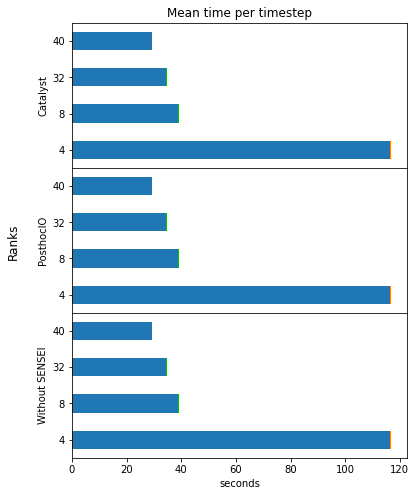

In [113]:
# Group the data by 'name' and 'rank' and calculate the mean 'delta' values for the desired columns
grouped_data = df[result['name'].str.contains('CatalystAnalysisAdaptor::Execute|CatalystAnalysisAdaptor::Initialize|CatalystAnalysisAdaptor::Finalize')]
grouped_data = grouped_data.groupby(['name', 'total_ranks', 'category', 'site'])['delta'].mean().reset_index()

def plot_mean_time_per_timestep(df):
    catalyst = df[df['category'] == 'catalyst']
    posthocio = df[df['category'] == 'posthocio']
    no_sensei = df[df['category'] == 'no_sensei']

    # Pivot the data to have 'rank' as columns and 'name' as index
    catalyst = catalyst.pivot(index='total_ranks', columns='name', values='delta')
    posthocio = posthocio.pivot(index='total_ranks', columns='name', values='delta')
    no_sensei = no_sensei.pivot(index='total_ranks', columns='name', values='delta')

    # Sort the index in ascending order
    catalyst.sort_index(ascending=True, inplace=True)
    posthocio.sort_index(ascending=True, inplace=True)
    no_sensei.sort_index(ascending=True, inplace=True)

    fig, axs = plt.subplots(3, figsize=(6,8), sharex=True)

    # Plot the stacked bar graph with axes flipped
    catalyst.plot(ax=axs[0], kind='barh', stacked=True)
    posthocio.plot(ax=axs[1], kind='barh', stacked=True)
    no_sensei.plot(ax=axs[2], kind='barh', stacked=True)

    # Bring subplots close to each other.
    fig.subplots_adjust(hspace=0)
    fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

    for ax in axs:
        ax.yaxis.set_label_position('left')
        ax.get_legend().remove()
        ax.label_outer()

    # Set the title and labels
    axs[0].set_title('Mean time per timestep')
    axs[0].set_ylabel("Catalyst")
    axs[1].set_ylabel("PosthocIO")
    axs[2].set_ylabel("Without SENSEI")

    axs[2].set_xlabel("seconds")

    # Show the plot
    plt.show()
    
plot_mean_time_per_timestep(grouped_data[grouped_data['site'] == 'alcf'])
#plot_mean_time_per_timestep(grouped_data[grouped_data['site'] == 'julich'])

# Average Memory per rank

In [155]:
dataframes = []
# Iterate over each file in the directory
for site in sites:
    for cat in categories:
        path = os.path.join(directory, site, cat)
        for filename in os.listdir(path):
            if "MemProf" in filename and filename.endswith(".csv"):
                ranks = filename.split("-")[-1].split(".")[0]
                file_path = os.path.join(path, filename)
                data = pd.read_csv(file_path)
                data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
                data['total_ranks'] = ranks
                data['category'] = cat
                data['site'] = site
                dataframes.append(data)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Convert 'Total Ranks' to integers
df['total_ranks'] = df['total_ranks'].astype(int)

# Covert to MB
df['memory_mb'] = df['memory_kib'] / 1024

# Covert to GB
df['memory_gb'] = df['memory_mb'] / 1024


In [156]:
df.head()

,rank,time,memory_kib,total_ranks,category,site,memory_mb,memory_gb
0,0,1.686949e+09,2649668,40,catalyst,alcf,2587.566406,2.526920
1,1,1.686949e+09,2633344,40,catalyst,alcf,2571.625000,2.511353
2,2,1.686949e+09,2722556,40,catalyst,alcf,2658.746094,2.596432
3,3,1.686949e+09,2639480,40,catalyst,alcf,2577.617188,2.517204
4,4,1.686949e+09,2668084,40,catalyst,alcf,2605.550781,2.544483


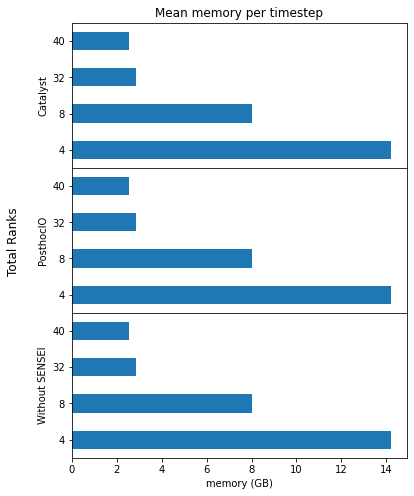

In [157]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = df.groupby(['total_ranks', 'category', 'site'])['memory_gb'].mean().reset_index()

def plot_mean_memory_per_timestep(df):
    catalyst = df[sum_avg_memory['category'] == 'catalyst']
    posthocio = df[sum_avg_memory['category'] == 'posthocio']
    no_sensei = df[sum_avg_memory['category'] == 'no_sensei']

    # Sort the index in ascending order
    catalyst.sort_index(ascending=True, inplace=True)
    posthocio.sort_index(ascending=True, inplace=True)
    no_sensei.sort_index(ascending=True, inplace=True)

    fig, axs = plt.subplots(3, figsize=(6,8), sharex=True)

    # Plot the stacked bar graph with axes flipped
    catalyst.plot(ax=axs[0], kind='barh', x='total_ranks', y='memory_gb')
    posthocio.plot(ax=axs[1], kind='barh', x='total_ranks', y='memory_gb')
    no_sensei.plot(ax=axs[2], kind='barh', x='total_ranks', y='memory_gb')

    # Bring subplots close to each other.
    fig.subplots_adjust(hspace=0)
    fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

    for ax in axs:
        ax.yaxis.set_label_position('left')
        ax.get_legend().remove()
        ax.label_outer()

    # Set the title and labels
    axs[0].set_title('Mean memory per timestep')
    axs[0].set_ylabel("Catalyst")
    axs[1].set_ylabel("PosthocIO")
    axs[2].set_ylabel("Without SENSEI")

    axs[2].set_xlabel("memory (GB)")
    plt.show()


plot_mean_memory_per_timestep(sum_avg_memory[sum_avg_memory['site'] == 'alcf'])
#plot_mean_memory_per_timestep(sum_avg_memory[sum_avg_memory['site'] == 'julich'])

<AxesSubplot:xlabel='total_ranks'>

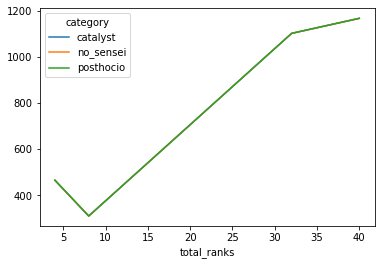

In [268]:
tmp = df[df['name'].str.contains('ConfigurableAnalysis::Execute')]
#tmp = tmp[tmp['name'].str.contains('Execute')]
tmp

tmp = tmp.groupby(['total_ranks', 'category', 'site'])['delta'].sum().reset_index()

tmp = tmp.pivot_table(values="delta",index="total_ranks",columns="category")
tmp
#fig, axs = plt.subplots()

# Plot the stacked bar graph with axes flipped
tmp.plot()
#alcf_no_sensei_8.plot(ax=axs, kind='line', x='timestep', y='memory_gb', label='8')
#alcf_no_sensei_32.plot(ax=axs, kind='line', x='timestep', y='memory_gb', label='32')
#alcf_no_sensei_40.plot(ax=axs, kind='line', x='timestep', y='memory_gb', label='40')


In [226]:
from statistics import mean 

dataframes = {}
# Iterate over each file in the directory
for site in sites:
    for cat in categories:
        path = os.path.join(directory, site, cat)
        for filename in os.listdir(path):
            if "MemProf" in filename and filename.endswith(".csv"):
                ranks = filename.split("-")[-1].split(".")[0]
                file_path = os.path.join(path, filename)
                data = pd.read_csv(file_path)
                data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
                data['total_ranks'] = ranks
                dataframes[site + cat + ranks] = data
                print("Adding " + site + " and " + cat + " and ranks " + ranks)

def calculate_memory_usage(df):
    memory_usage = {}

    index = 0
    N = df[df['rank'] == 0].count()['rank']
    res = df['memory_kib'].values.reshape(-1, N)
    res_time = df['time'].values.reshape(-1, N)
    total_sum = [sum(x) for x in zip(*res)]
    time = [mean(x) for x in zip(*res_time)]

    timestep = 0
    for ts in total_sum:
        memory_usage[str(index)] = {'memory_kib': ts, 'timestep': timestep, 'time': time[index]}
        timestep = timestep + 1
        index = index + 1
    #memory_usage
    memory_df = pd.DataFrame(memory_usage).transpose()
    # Covert to MB
    memory_df['memory_mb'] = memory_df['memory_kib'] / 1024

    # Covert to GB
    memory_df['memory_gb'] = memory_df['memory_mb'] / 1024
    
    return memory_df

Adding alcf and catalyst and ranks 40
Adding alcf and catalyst and ranks 32
Adding alcf and catalyst and ranks 4
Adding alcf and catalyst and ranks 8
Adding alcf and posthocio and ranks 40
Adding alcf and posthocio and ranks 32
Adding alcf and posthocio and ranks 4
Adding alcf and posthocio and ranks 8
Adding alcf and no_sensei and ranks 40
Adding alcf and no_sensei and ranks 32
Adding alcf and no_sensei and ranks 4
Adding alcf and no_sensei and ranks 8


,memory_kib,timestep,time,memory_mb,memory_gb
0,60958708.0,0.0,1.686932e+09,59529.988281,58.134754
1,73849732.0,1.0,1.686932e+09,72118.878906,70.428593


<AxesSubplot:xlabel='timestep'>

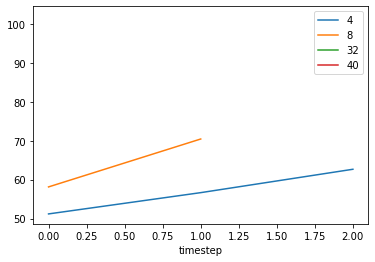

In [228]:
fig, axs = plt.subplots()

alcf_no_sensei_4 = calculate_memory_usage(dataframes['alcf' + 'no_sensei' + '4'])
alcf_no_sensei_8 = calculate_memory_usage(dataframes['alcf' + 'no_sensei' + '8'])
alcf_no_sensei_32 = calculate_memory_usage(dataframes['alcf' + 'no_sensei' + '32'])
alcf_no_sensei_40 = calculate_memory_usage(dataframes['alcf' + 'no_sensei' + '40'])

# Plot the stacked bar graph with axes flipped
alcf_no_sensei_4.plot(ax=axs, kind='line', x='timestep', y='memory_gb', label='4')
alcf_no_sensei_8.plot(ax=axs, kind='line', x='timestep', y='memory_gb', label='8')
alcf_no_sensei_32.plot(ax=axs, kind='line', x='timestep', y='memory_gb', label='32')
alcf_no_sensei_40.plot(ax=axs, kind='line', x='timestep', y='memory_gb', label='40')


,total_ranks,memory_kib,timestep,memory_mb,memory_gb
0,40,106874004,0,104369.144531,101.922993
1,40,106874004,1,104369.144531,101.922993
2,40,106874004,2,104369.144531,101.922993
3,32,96261604,0,94005.472656,91.802219
4,32,96261604,1,94005.472656,91.802219
5,32,96261604,2,94005.472656,91.802219
6,4,53693444,0,52435.003906,51.206059
7,4,59416172,1,58023.605469,56.663677
8,4,65706132,2,64166.144531,62.662251
9,4,53693444,3,52435.003906,51.206059


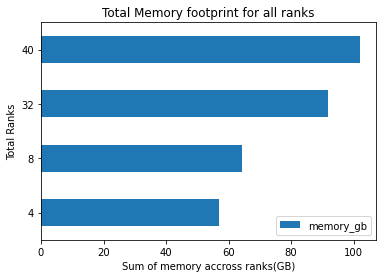

In [164]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = memory_df.groupby('total_ranks')['memory_gb'].mean().reset_index()

# Convert 'Total Ranks' to integers
sum_avg_memory['total_ranks'] = sum_avg_memory['total_ranks'].astype(int)

# Sort the index in ascending order
sum_avg_memory = sum_avg_memory.sort_values('total_ranks')


# Plot the sum of average memory_gb over time by 'total_ranks' with axes flipped
sum_avg_memory.plot(kind='barh', x='total_ranks', y='memory_gb')
#plt.barh()

# Set the title and labels
plt.title('Total Memory footprint for all ranks')
plt.xlabel('Sum of memory accross ranks(GB)')
plt.ylabel('Total Ranks')

# Show the plot
plt.show()

In [165]:
memory_df.groupby('total_ranks')['memory_gb'].mean().reset_index()

,total_ranks,memory_gb
0,4,56.843995
1,8,64.281673
2,32,91.802219
3,40,101.922993


In [279]:
# Iterate over each file in the directory
for site in sites:
    path = os.path.join(directory, site)
    file_path = os.path.join(path, "time_to_solution.csv")
    df = pd.read_csv(file_path)
    df['site'] = site
    
df

,ranks,category,time,site
0,4,catalyst,258.0280,alcf
1,8,catalyst,128.3650,alcf
2,32,catalyst,89.4762,alcf
3,40,catalyst,85.5241,alcf
4,4,posthocio,25.0280,alcf
5,8,posthocio,12.3650,alcf
6,32,posthocio,8.4762,alcf
7,40,posthocio,8.5241,alcf
8,4,no_sensei,2.0280,alcf
9,8,no_sensei,1.3650,alcf


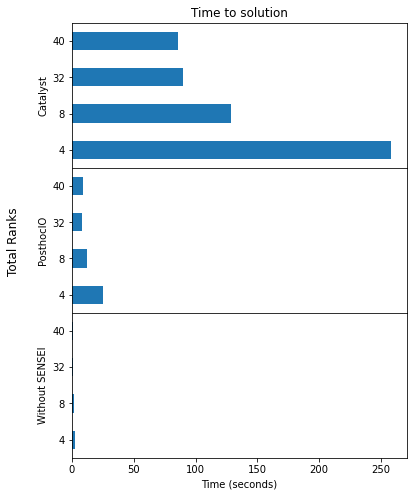

In [283]:

catalyst = df[df['category'] == 'catalyst']
posthocio = df[df['category'] == 'posthocio']
no_sensei = df[df['category'] == 'no_sensei']

# Sort the index in ascending order
catalyst.sort_index(ascending=True, inplace=True)
posthocio.sort_index(ascending=True, inplace=True)
no_sensei.sort_index(ascending=True, inplace=True)

fig, axs = plt.subplots(3, figsize=(6,8), sharex=True)

# Plot the stacked bar graph with axes flipped
catalyst.plot(ax=axs[0], kind='barh', x='ranks', y='time')
posthocio.plot(ax=axs[1], kind='barh', x='ranks', y='time')
no_sensei.plot(ax=axs[2], kind='barh', x='ranks', y='time')

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

for ax in axs:
    ax.yaxis.set_label_position('left')
    ax.get_legend().remove()
    ax.label_outer()

# Set the title and labels
axs[0].set_title('Time to solution')
axs[0].set_ylabel("Catalyst")
axs[1].set_ylabel("PosthocIO")
axs[2].set_ylabel("Without SENSEI")

axs[2].set_xlabel("Time (seconds)")
plt.show()